In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IA.utils import mapping, parameter_range
from scipy import stats
import math
from pathlib import Path

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import svm

from collections import defaultdict

In [46]:
test_files = list(pd.read_csv("analysis/not_uploaded/AVA_test.csv")["file"])
gt = pd.read_csv("analysis/not_uploaded/AVA_gt.txt", sep=" ").drop(columns=["Unnamed: 0", "semanticTagID1", "semanticTagID2", "challengeID"])
df = pd.read_csv("analysis/not_uploaded/IA/AVA/.scratch.ckpts.IA.pexels.scores-one.change_regress.epoch-9.pth.txt")

df["img"] = df["img"].apply(lambda row: Path(row).stem)
df["score"] = df["score"].apply(lambda row: eval(row)[0])

gt["votes"] = gt.apply(lambda row: sum(list(row)[1:]), axis=1)
gt["gt_score"] = gt.apply(lambda row: sum([val * (i + 1) for i, val in enumerate(list(row)[1:-1])]), axis=1)
gt["gt_score"] = gt.apply(lambda row: row.gt_score / row.votes, axis=1)
gt["gt_quality"] = gt["gt_score"].apply(lambda row: 1 if row > 5 else 0)
gt = gt.drop(columns=[str(i) for i in range(1,11)] + ["votes"])

df["img"] = df["img"].astype(int)
gt["img"] = gt["img"].astype(int)

df = df.set_index("img")
gt = gt.set_index("img")

df = gt.join(df).dropna().drop_duplicates()
df["mode"] = df.index.isin(test_files)
df["mode"] = df["mode"].apply(lambda row: "test" if row else "train")

train_df = df[df["mode"] == "train"]
test_df = df[df["mode"] == "test"]

df

,gt_score,gt_quality,score,styles_contrast_strength,styles_brightness_strength,styles_saturation_strength,styles_shadows_strength,styles_highlights_strength,styles_exposure_strength,styles_vibrance_strength,...,technical_pixelate_strength,technical_gaussian_noise_strength,technical_impulse_noise_strength,composition_rotate_strength,composition_hcrop_strength,composition_vcrop_strength,composition_leftcornerscrop_strength,composition_rightcornerscrop_strength,composition_ratio_strength,mode
img,,,,,,,,,,,,,,,,,,,,,
53,7.104651,1,0.778320,0.003284,0.362549,0.570312,0.049652,0.371582,0.495117,0.177246,...,0.354248,-0.094604,-0.051453,-0.057709,0.183960,0.243530,0.243652,0.205322,0.133911,train
54,4.534884,0,0.740234,0.175903,0.151855,0.392090,0.274414,0.147095,0.310547,0.118103,...,0.331299,-0.041382,-0.055695,0.055634,0.086731,0.302979,0.370117,0.315430,0.644531,train
66,4.694118,0,0.742188,0.569336,-0.360596,-0.364990,-0.219604,0.089722,-0.336670,-0.012573,...,-0.075684,-0.027435,-0.044464,0.246460,0.143677,-0.367676,-0.359375,-0.362549,0.599121,train
69,4.858824,0,0.943359,0.148438,0.021988,0.031097,-0.504395,0.540039,-0.126831,0.077087,...,0.266602,-0.106445,-0.144775,-0.038544,-0.277344,0.122559,0.136597,0.105103,0.110474,train
70,5.686047,1,0.690918,0.373779,-0.168457,0.057770,-0.339355,0.189941,-0.034851,0.098450,...,0.180908,-0.033630,-0.034546,-0.104858,-0.165771,0.200806,0.199951,0.148560,-0.170044,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958282,5.733333,1,0.120422,0.400879,-0.322266,0.541992,-0.110107,0.510254,0.209351,0.192993,...,0.475098,0.204224,0.227905,0.001126,0.063354,0.075806,0.039215,0.052795,0.298828,train
958284,6.432000,1,0.619629,0.312988,-0.079590,0.290527,-0.075012,0.151123,0.112488,0.155273,...,0.410645,0.144531,0.127563,0.020859,0.120728,0.061707,0.065613,0.004318,0.272217,train
958285,4.428571,0,0.760254,0.172241,0.113892,-0.373779,-0.138306,0.183228,-0.008904,0.027618,...,0.226196,0.099915,0.083984,0.091125,-0.050293,-0.039307,-0.070984,-0.048523,-0.294434,train


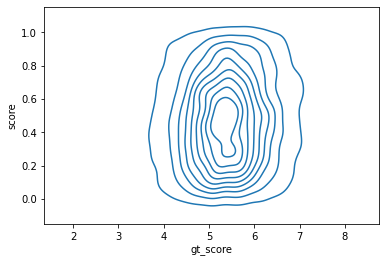

In [47]:
sns.kdeplot(data=test_df, x="gt_score", y="score")

In [48]:
stats.pearsonr(test_df["gt_score"], test_df["score"])

(0.059874123601879395, 1.1675531510478439e-11)

In [49]:
test_df.columns

Index(['gt_score', 'gt_quality', 'score', 'styles_contrast_strength',
       'styles_brightness_strength', 'styles_saturation_strength',
       'styles_shadows_strength', 'styles_highlights_strength',
       'styles_exposure_strength', 'styles_vibrance_strength',
       'styles_temperature_strength', 'styles_tint_strength',
       'technical_jpeg_compression_strength',
       'technical_defocus_blur_strength', 'technical_motion_blur_strength',
       'technical_pixelate_strength', 'technical_gaussian_noise_strength',
       'technical_impulse_noise_strength', 'composition_rotate_strength',
       'composition_hcrop_strength', 'composition_vcrop_strength',
       'composition_leftcornerscrop_strength',
       'composition_rightcornerscrop_strength', 'composition_ratio_strength',
       'mode'],
      dtype='object')

In [51]:
features = [c for c in df.columns if c not in ["gt_score", "gt_quality", "mode"]]

In [58]:
reg = svm.SVR()
reg.fit(train_df[features], train_df["gt_score"])
reg.score(test[features], test["gt_score"])

In [ ]:
reg.predict(test[features])

In [ ]:
sns.kdeplot(x=test_df["gt_score"], y=reg.predict(test[features]))